<a href="https://colab.research.google.com/github/yashanecha/DeepFace-Classifier/blob/Sub/Improved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 961.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

In [ ]:
!pip install umap-learn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from PIL import Image
from sklearn.utils.multiclass import unique_labels
import plotly.express as px
from umap import UMAP
import warnings
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from torchvision.transforms.functional import rotate
from collections import Counter

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Load the Pre-trained Inception model
print("loading the model...")
model = InceptionResnetV1(pretrained='vggface2').eval()
print("model loaded Sucessfully")


loading the model...


  0%|          | 0.00/107M [00:00<?, ?B/s]

model loaded Sucessfully


In [ ]:
# Define image transformations
base_transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Ensure the correct size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize as expected by the model
])

In [ ]:
def augment_image(image):
    """Apply data augmentation to a PIL image."""
    augmentations = [
        rotate(image, angle) for angle in [-15, -10, 10, 15]
    ]
    return augmentations

In [ ]:
def extract_features(image_path, augment=False):
    """Extract embedding features for a face image using FaceNet."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read the image from {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_pil = Image.fromarray(img_rgb)  # Convert NumPy array to PIL image

    embeddings = []
    images_to_process = [img_pil]

    if augment:
        images_to_process += augment_image(img_pil)

    for img in images_to_process:
        img_tensor = base_transform(img).unsqueeze(0)  # Transform and add batch dimension
        with torch.no_grad():
            embedding = model(img_tensor).squeeze().numpy()
            embeddings.append(embedding)

    return embeddings


In [ ]:
def load_dataset(dataset_path, sample_size=1000):
    """Load dataset and extract embeddings and labels."""
    embeddings = []
    labels = []

    for root, _, files in os.walk(dataset_path):
        label = os.path.basename(root)
        for file in files:
            if not file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Validate image extensions
                continue
            file_path = os.path.join(root, file)
            try:
                augmented_embeddings = extract_features(file_path, augment=True)
                embeddings.extend(augmented_embeddings)
                labels.extend([label] * len(augmented_embeddings))
                if len(embeddings) >= sample_size:  # Stop when reaching the sample size
                    return np.array(embeddings), labels
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

    return np.array(embeddings), labels

def train_classifier(X_train, y_train):
    """Train an SVM classifier."""
    clf = SVC(kernel='linear', probability=True, class_weight='balanced')
    clf.fit(X_train, y_train)
    return clf

def plot_embeddings_with_umap(embeddings, labels, label_decoder):
    """Visualize high-dimensional embeddings in 2D space using UMAP."""
    reducer = UMAP(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    labels_decoded = [label_decoder[label] for label in labels]

    # Use Plotly for interactive visualization
    fig = px.scatter(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        color=labels_decoded,
        title="UMAP Visualization of Embeddings",
        labels={'color': 'Identity'},
        template="plotly_white"
    )
    fig.update_traces(marker=dict(size=7, opacity=0.7))
    fig.show()


In [ ]:
# Class Distribution Plot
def plot_class_distribution(labels):
    """Plots class distribution."""
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels, order=np.unique(labels))
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_encoder, sample_size=20):
    """Plots the confusion matrix with limited samples."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    # Limit labels to the first 20 classes
    limited_classes = label_encoder.classes_[:20]

    # Limit the confusion matrix to 20x20
    cm = cm[:20, :20]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=limited_classes, yticklabels=limited_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Limited to 20 Classes)')
    plt.show()

Loading dataset and extracting features...
Encoding labels...
Balancing dataset using SMOTE...
Splitting dataset...
Training classifier...
Evaluating classifier...
Accuracy: 1.00
Classification Report:
                        precision    recall  f1-score   support

           Cha_Yung-gu       1.00      1.00      1.00        17
       Charles_Holzner       1.00      1.00      1.00        12
       Charles_Mathews       1.00      1.00      1.00        11
         Charles_Moose       1.00      1.00      1.00         6
        Charles_Rogers       1.00      1.00      1.00         9
       Charles_Schumer       1.00      1.00      1.00        13
        Charles_Tannok       1.00      1.00      1.00        14
        Charles_Taylor       1.00      1.00      1.00        10
         Charley_Armey       1.00      1.00      1.00        11
         Charlie_Coles       1.00      1.00      1.00         8
         Charlie_Deane       1.00      1.00      1.00        11
        Charlie_Garner       

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Plotting class distribution...


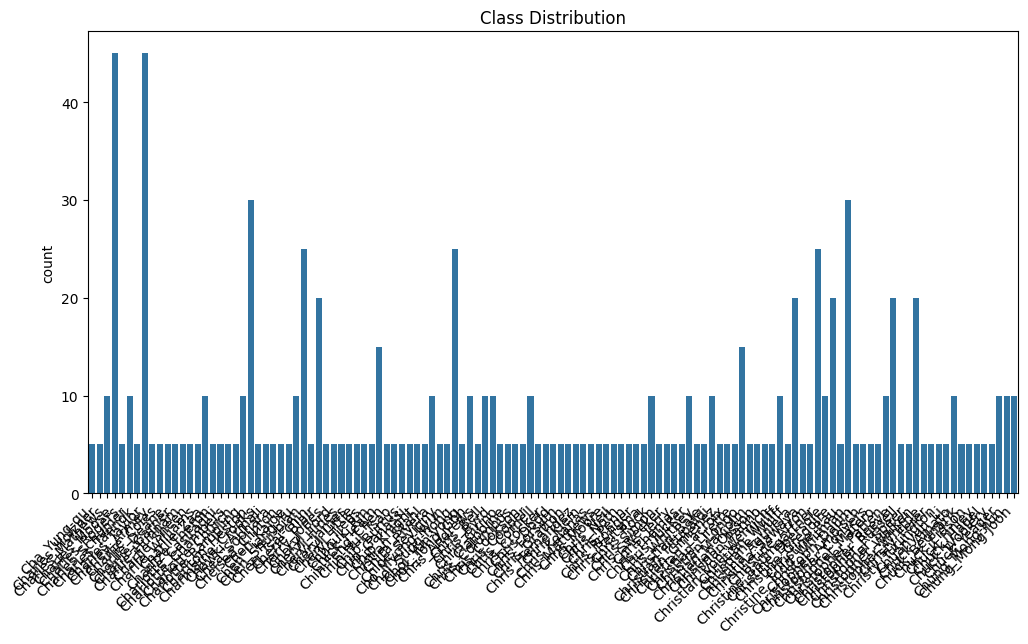

In [ ]:
if __name__ == "__main__":
    # Path to the LFW dataset
    dataset_path = r"/content/drive/MyDrive/lfw-deepfunneled"

    print("Loading dataset and extracting features...")
    embeddings, labels = load_dataset(dataset_path, sample_size=1000)  # Limit to 1000 samples

    print("Encoding labels...")
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Create a mapping for decoding labels
    label_decoder = {idx: label for idx, label in enumerate(label_encoder.classes_)}

    print("Balancing dataset using SMOTE...")
    min_samples_per_class = min(Counter(encoded_labels).values())
    smote = SMOTE(random_state=42, k_neighbors=min(min_samples_per_class - 1, 5))
    embeddings, encoded_labels = smote.fit_resample(embeddings, encoded_labels)

    print("Splitting dataset...")
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, encoded_labels, test_size=0.25, random_state=42
    )

    print("Training classifier...")
    classifier = train_classifier(X_train, y_train)

    print("Evaluating classifier...")
    y_pred = classifier.predict(X_test)

    unique_classes = unique_labels(y_test, y_pred)
    target_names = [label_decoder[class_idx] for class_idx in unique_classes]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:")
    print(classification_report(
        y_test, y_pred, target_names=target_names, labels=unique_classes
    ))

    print("Visualizing embeddings...")
    plot_embeddings_with_umap(embeddings, encoded_labels, label_decoder)

    print("Plotting class distribution...")
    plot_class_distribution(labels)

Plotting confusion matrix ...


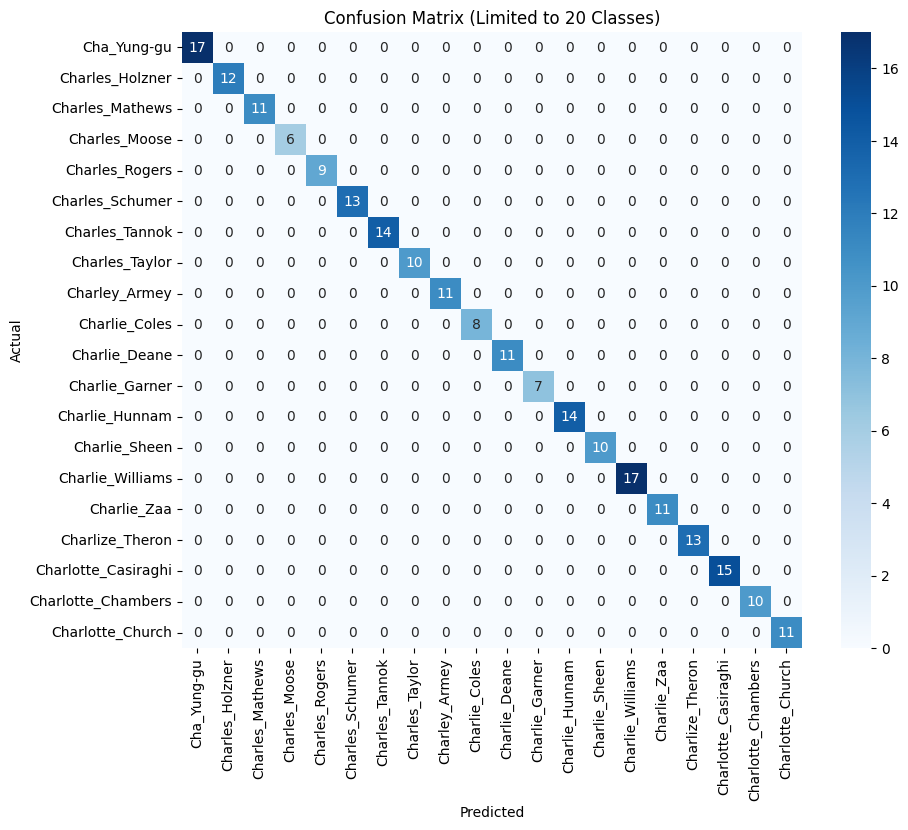

In [ ]:
print("Plotting confusion matrix ...")
plot_confusion_matrix(y_test, y_pred, label_encoder, sample_size=10)